# BERT Model

In [1]:
import numpy as np
import wandb
from datasets import load_dataset
from transformers import AutoTokenizer
import tensorflow as tf

c:\Users\asaju\Desktop\ANLP\Intent-Classification\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = load_dataset("silicone", "maptask")

Dataset silicone downloaded and prepared to C:/Users/asaju/.cache/huggingface/datasets/silicone/maptask/1.0.0/af617406c94e3f78da85f7ea74ebfbd3f297a9665cb54adbae305b03bc4442a5. Subsequent calls will reuse this data.


100%|██████████| 3/3 [00:00<00:00, 149.34it/s]


In [3]:
# Separate the dataset into train val and test
train_dataset = dataset["train"]
val_dataset = dataset["validation"]
test_dataset = dataset["test"]

# Separate X (Utterance) and y (Dialogue_Act)
train_X = train_dataset["Utterance"]
train_y = train_dataset["Label"]

val_X = val_dataset["Utterance"]
val_y = val_dataset["Label"]

test_X = test_dataset["Utterance"]
test_y = test_dataset["Label"]

# Convert y from int to one-hot
train_y = tf.keras.utils.to_categorical(train_y)
val_y = tf.keras.utils.to_categorical(val_y)
test_y = tf.keras.utils.to_categorical(test_y)

In [4]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from transformers import AutoTokenizer, TFBertModel 

tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert = TFBertModel.from_pretrained('bert-base-cased')

# Tokenize the data
train_encodings = tokenizer(train_X, truncation=True, padding=True)
val_encodings = tokenizer(val_X, truncation=True, padding=True)
test_encodings = tokenizer(test_X, truncation=True, padding=True)

# Pad val_encodings and test_encodings to 124
val_encodings['input_ids'] = tf.keras.preprocessing.sequence.pad_sequences(val_encodings['input_ids'], maxlen=124, dtype="long", value=0, truncating="post", padding="post")
val_encodings['attention_mask'] = tf.keras.preprocessing.sequence.pad_sequences(val_encodings['attention_mask'], maxlen=124, dtype="long", value=0, truncating="post", padding="post")

test_encodings['input_ids'] = tf.keras.preprocessing.sequence.pad_sequences(test_encodings['input_ids'], maxlen=124, dtype="long", value=0, truncating="post", padding="post")
test_encodings['attention_mask'] = tf.keras.preprocessing.sequence.pad_sequences(test_encodings['attention_mask'], maxlen=124, dtype="long", value=0, truncating="post", padding="post")

# Convert the data to tf dataset
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_y
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_y
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_y
))

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [5]:
# Fine tune BERT on the Maptask dataset
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense

input_ids = Input(shape=(124,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(124,), dtype=tf.int32, name="attention_mask")
# embeddings = dbert_model(input_ids, attention_mask = input_mask)[0]

embeddings = bert(input_ids, attention_mask = input_mask)[0] # 0 = last hidden state, 1 = poller_output
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(256, activation='relu')(out)
out = tf.keras.layers.Dropout(0.2)(out)

y = Dense(12, activation='softmax')(out)

model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

optimizer = Adam(
    learning_rate=5e-05, # HF recommendation
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0
)

loss = CategoricalCrossentropy(from_logits=True)
metric = CategoricalAccuracy('accuracy')

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metric
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 124)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 124)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 124,                                           

In [9]:
# Train
wandb.init(project="maptask")

# Callbacks
save_model = tf.keras.callbacks.ModelCheckpoint(filepath=wandb.run.dir + '/model.h5', save_best_only=True, monitor='val_loss', mode='min')

batch_size = 16

history = model.fit(
    train_dataset.shuffle(22000).batch(batch_size),
    validation_data=val_dataset.batch(batch_size),
    epochs=10,
    batch_size=batch_size,
    callbacks=[save_model, wandb.keras.WandbCallback()]
)

Epoch 1/10
1307/1307 [==============================] - ETA: 0s - loss: 1.1311 - accuracy: 0.6091

c:\Users\asaju\Desktop\ANLP\Intent-Classification\venv\lib\site-packages\keras\engine\functional.py:637: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
c:\Users\asaju\Desktop\ANLP\Intent-Classification\venv\lib\site-packages\keras\backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


INFO:tensorflow:Assets written to: c:\Users\asaju\Desktop\ANLP\Intent-Classification\wandb\run-20230404_144734-vk6odbjh\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\asaju\Desktop\ANLP\Intent-Classification\wandb\run-20230404_144734-vk6odbjh\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\asaju\Desktop\ANLP\Intent-Classification\wandb\run-20230404_144734-vk6odbjh\files\model-best)... Done. 3.1s


1307/1307 [==============================] - 325s 249ms/step - loss: 1.1311 - accuracy: 0.6091 - val_loss: 1.0715 - val_accuracy: 0.6267
Epoch 2/10
1307/1307 [==============================] - ETA: 0s - loss: 1.0054 - accuracy: 0.6442

INFO:tensorflow:Assets written to: c:\Users\asaju\Desktop\ANLP\Intent-Classification\wandb\run-20230404_144734-vk6odbjh\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\asaju\Desktop\ANLP\Intent-Classification\wandb\run-20230404_144734-vk6odbjh\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\asaju\Desktop\ANLP\Intent-Classification\wandb\run-20230404_144734-vk6odbjh\files\model-best)... Done. 3.1s


1307/1307 [==============================] - 321s 245ms/step - loss: 1.0054 - accuracy: 0.6442 - val_loss: 1.0603 - val_accuracy: 0.6264
Epoch 3/10
1307/1307 [==============================] - 286s 218ms/step - loss: 0.9696 - accuracy: 0.6548 - val_loss: 1.0651 - val_accuracy: 0.5856
Epoch 4/10
1307/1307 [==============================] - 286s 219ms/step - loss: 0.9453 - accuracy: 0.6592 - val_loss: 1.0632 - val_accuracy: 0.6115
Epoch 5/10
1307/1307 [==============================] - 285s 218ms/step - loss: 0.9299 - accuracy: 0.6619 - val_loss: 1.0616 - val_accuracy: 0.6284
Epoch 6/10
1244/1307 [===========================>..] - ETA: 13s - loss: 0.9138 - accuracy: 0.6692

KeyboardInterrupt: 

In [10]:
# Load the best model
model.load_weights(wandb.run.dir + '/model.h5')

In [11]:
# Evaluate
model.evaluate(test_dataset.batch(batch_size))

c:\Users\asaju\Desktop\ANLP\Intent-Classification\venv\lib\site-packages\keras\engine\functional.py:637: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
c:\Users\asaju\Desktop\ANLP\Intent-Classification\venv\lib\site-packages\keras\backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


181/181 [==============================] - 15s 73ms/step - loss: 1.0806 - accuracy: 0.6341


[1.0806057453155518, 0.6340705156326294]

c:\Users\asaju\Desktop\ANLP\Intent-Classification\venv\lib\site-packages\keras\engine\functional.py:637: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


181/181 [==============================] - 14s 71ms/step


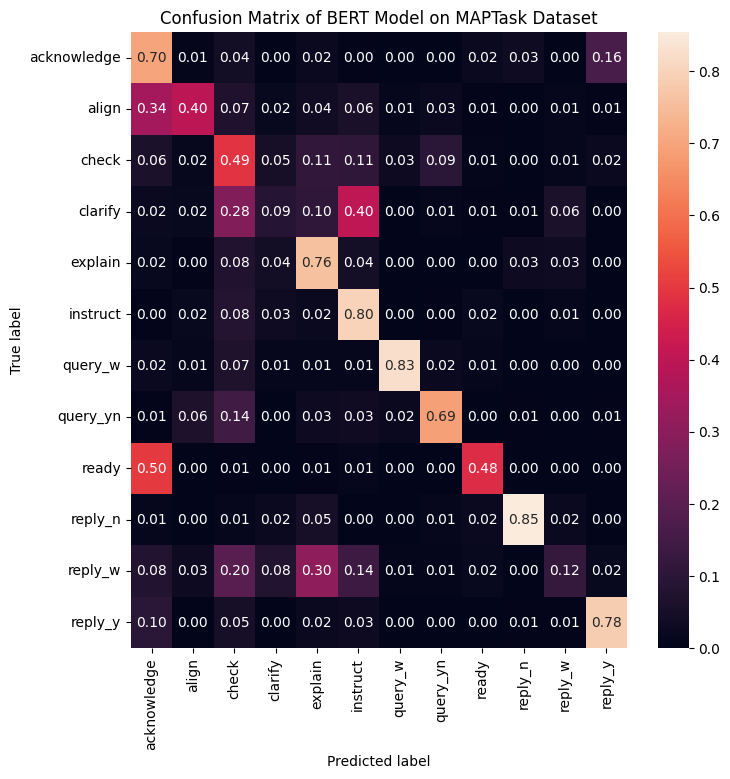

In [12]:
# Plot the confusion matrix of the 12 labels
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(test_dataset.batch(batch_size))
y_pred = np.argmax(y_pred, axis=1)
y_test_plot = np.argmax(test_y, axis=1)

cm = confusion_matrix(y_test_plot, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 8))
plt.title('Confusion Matrix of BERT Model on MAPTask Dataset')
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=dataset["train"].features["Label"].names, yticklabels=dataset["train"].features["Label"].names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
